In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [3]:
pathToData = '../cmake-build-release'
pathToData = '.'

# General memory Usage

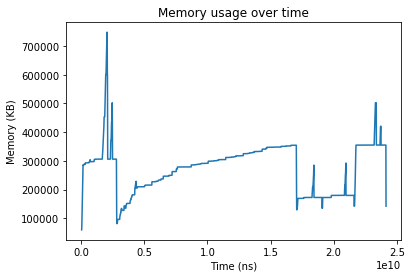

In [4]:
# Plot the memory usage over time for the whole pipeline
alloc_df = pd.read_csv('{}/allocation{}.csv'.format(pathToData,"s1"))
alloc_df = alloc_df.dropna()
sns.lineplot(x="time", y="rss_kb", data=alloc_df)
plt.title('Memory usage over time')
plt.xlabel('Time (ns)')
plt.ylabel('Memory (KB)')
plt.savefig('mem_usage_over_time.png')
plt.show()

In [5]:
# Functions

conv_fc_layers = {
    'AgeNet': {'conv': 12, 'fc':8},
    'GenderNet': {'conv': 12, 'fc':8},
    'FaceNet': {'conv': 17, 'fc':8},
    'Salient Object Subitizing': {'conv': 16, 'fc':6},
    'Salient Object Subitizing_google': {'conv': 10, 'fc':142}
}

def process_run(df):
    df = df.dropna()
    norm_df_list = []
    for netId in df.networkId.unique():
        tmp_df = df[df.networkId == netId];
        min_bytes = tmp_df.rss_kb.min()
        tmp_df['bytes_norm'] = tmp_df.rss_kb - min_bytes
        tmp_df['bytes_mb_norm'] = tmp_df['bytes_norm']/1024
        norm_df_list.append(tmp_df)
    norm_df = pd.concat(norm_df_list)
    return norm_df

def get_max_per_layer(norm_df):
    return norm_df.groupby(['network','layerId', 'taskType']).max().reset_index()

def process_from_filename(filename):
    df = pd.read_csv(filename)
    df = process_run(df)
    df = get_max_per_layer(df)
    return df

def setfc_conv(df, network, dictionary):
    df.loc[(df['network']==network) & (df['layerId']< dictionary['conv']), "fc-conv"] = 'conv'
    df.loc[(df['network']==network) & (df['layerId']>= dictionary['conv']), "fc-conv"] = 'fc'
    
def fc_conv(original_df):
    df = original_df
    for network in df.network:
        dictionary = conv_fc_layers[network]
        df.loc[(df['network']==network) & (df['layerId']< dictionary['conv']), "fc-conv"] = 'conv'
        df.loc[(df['network']==network) & (df['layerId']>= dictionary['conv']), "fc-conv"] = 'fc'
    df = df[df.layerId > -1]
    df = df.groupby(['network', 'fc-conv']).max().reset_index()
    return df

list_of_df = []
list_of_conv_fc = []
for idx in range(1,11):
    calc_df = process_from_filename('./allocations{}.csv'.format(idx))
    conv_fc_df = fc_conv(calc_df)
    list_of_df.append(calc_df)
    list_of_conv_fc.append(conv_fc_df)

combined = pd.concat(list_of_df)
combined_fc_conv = pd.concat(list_of_conv_fc)

/home/bacox/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/bacox/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/bacox/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/bacox/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


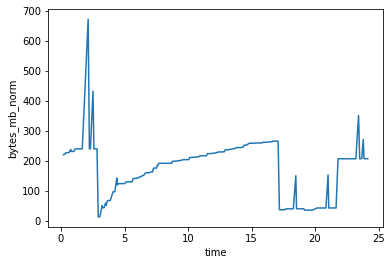

AgeNet


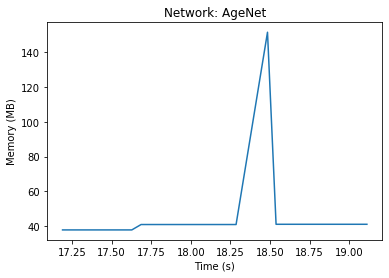

FaceNet


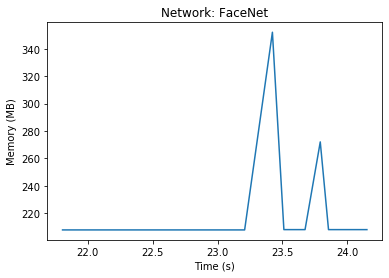

GenderNet


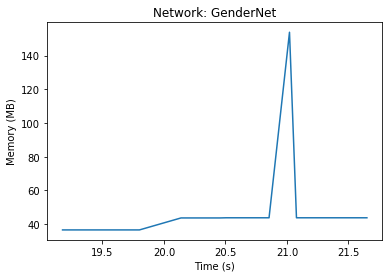

Salient Object Subitizing


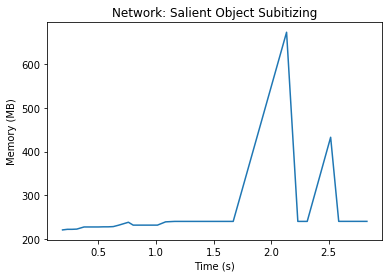

Salient Object Subitizing_google


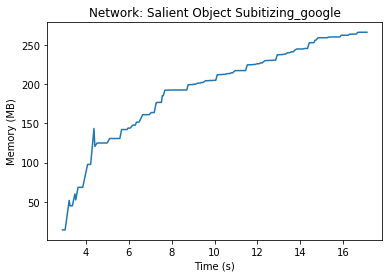

In [8]:
# Figures for the networks individually

raw_data = process_from_filename('{}/allocation{}.csv'.format(pathToData,"s1"))
raw_data['time'] = raw_data['time']/ (1000**3)

sns.lineplot(x="time", y="bytes_mb_norm", data=raw_data)
plt.show()

for network in raw_data.network.unique():
    print(network)
    single_df = raw_data[raw_data.network == network]
    sns.lineplot(x="time", y="bytes_mb_norm", data=single_df)
    plt.title('Network: {}'.format(network))
    plt.xlabel('Time (s)')
    plt.ylabel('Memory (MB)')
    plt.savefig('mem_usage_network_{}.png'.format(network.replace(" ", "_")))
    plt.show()

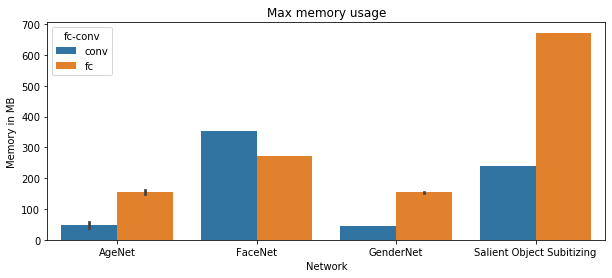

In [9]:
# Max usage of memory when split between convolutional and fully connected layers
tmp_df = combined_fc_conv.drop(combined_fc_conv[combined_fc_conv.network == 'Salient Object Subitizing_google'].index)
plt.figure(figsize=(10,4))
sns.barplot(x="network", y="bytes_mb_norm", hue="fc-conv", data=tmp_df)
plt.title('Max memory usage')
plt.xlabel('Network')
plt.ylabel('Memory in MB')
plt.savefig('max_mem_conv_fc_exlc.png')
plt.show()

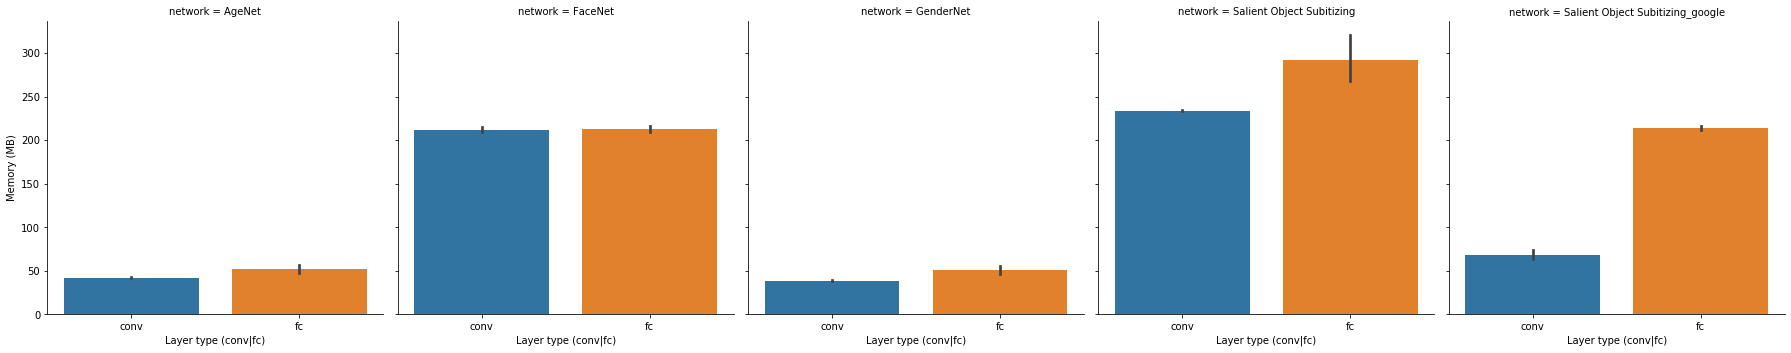

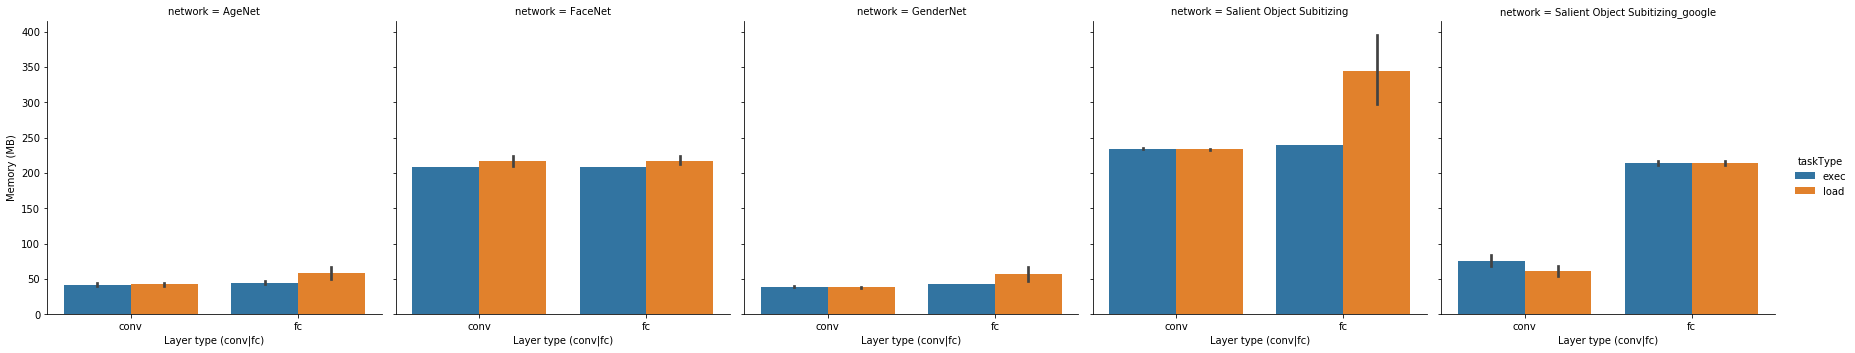

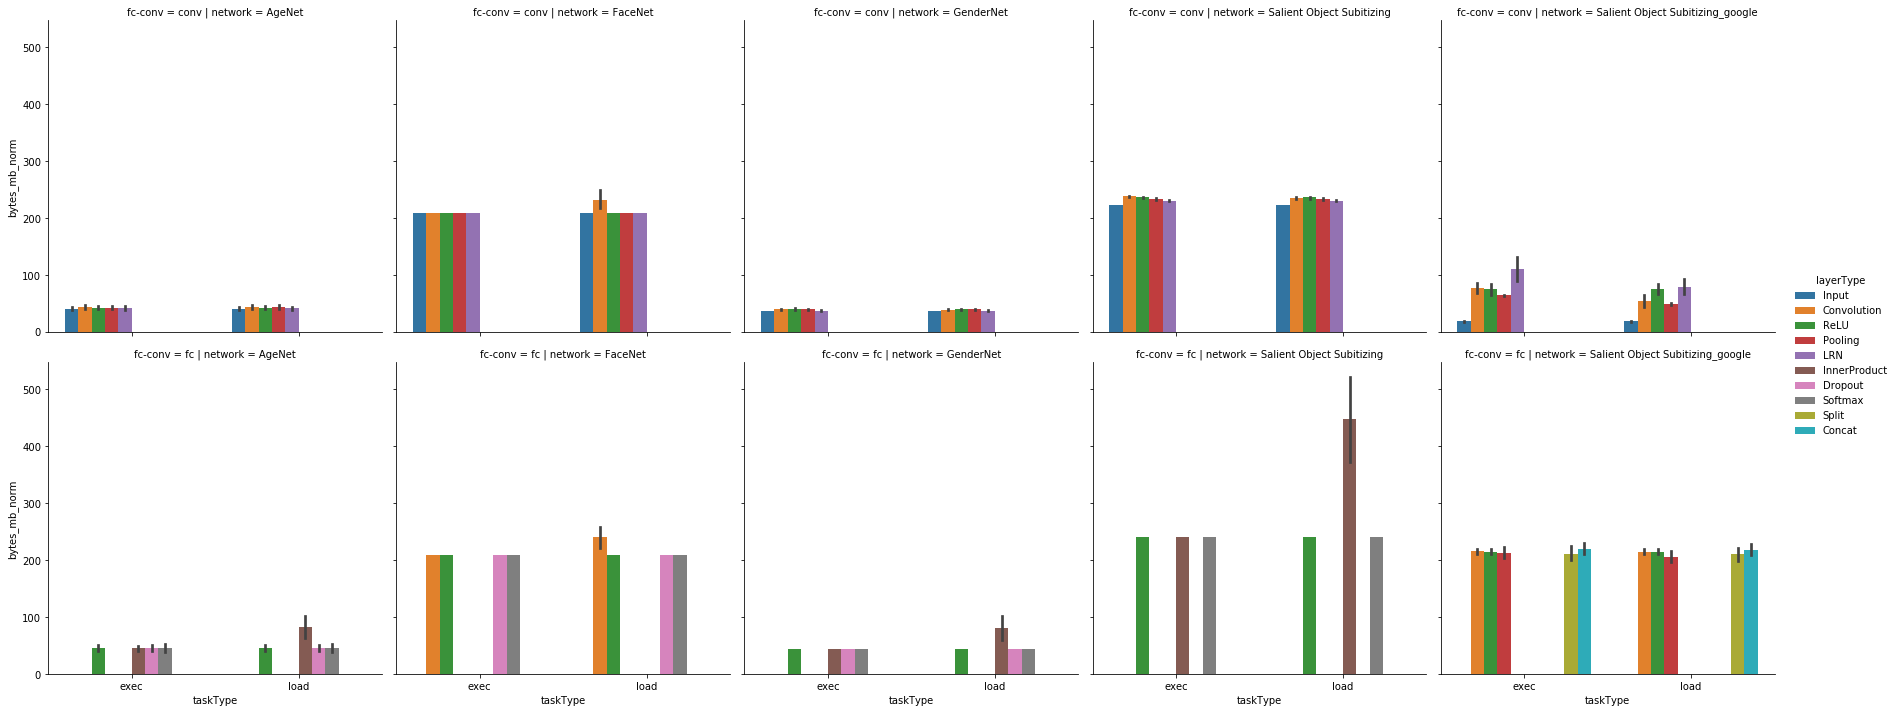

In [10]:
# Compare data between fc and conv layers and load and exec tasks
tmp2_df = combined.drop(combined[combined.network == 'Salient Object Subitizing_google'].index)
tmp2_df = combined
tmp2_df = tmp2_df.drop(tmp2_df[tmp2_df.taskType == 'init'].index)


cat_plot = sns.catplot("fc-conv", "bytes_mb_norm", col="network", data=tmp2_df, kind="bar")
cat_plot.set_xlabels('Layer type (conv|fc)')
cat_plot.set_ylabels('Memory (MB)')
plt.savefig('mem_fc_conv_split_all_tasks.png')

plt.show()
cat_plot2 = sns.catplot("fc-conv", "bytes_mb_norm", "taskType", col="network", data=tmp2_df, kind="bar")
cat_plot2.set_xlabels('Layer type (conv|fc)')
cat_plot2.set_ylabels('Memory (MB)')
plt.savefig('mem_fc_conv_split_per_task.png')

plt.show()

cat_plot3 = sns.catplot("taskType", "bytes_mb_norm", "layerType", row='fc-conv', col="network", data=tmp2_df, kind="bar")
cat_plot2.set_xlabels('Task type (Load|Exec)')
cat_plot2.set_ylabels('Memory (MB)')
plt.savefig('mem_split_overview.png')

plt.show()

# Profiler resolution
Calculate the resolution of profiler.

How fast can be measure the memory usage using the OS:

In [12]:
res_list = []
for idx in range(1,11):
    alloc_i = pd.read_csv('./allocations{}.csv'.format(idx))
    alloc_i = alloc_i.iloc[1:,:]
    tmp_res = (alloc_i.iloc[-1,:].time - alloc_i.iloc[0,:].time) / len(alloc_i)
    res_list.append(tmp_res)

print('Measuring resolution:')
print('Mean: {} ns'.format(np.mean(res_list)))
print('Std : {} ns'.format(np.std(res_list)))
print('Mean: {} us'.format(np.mean(res_list)/1000))

Measuring resolution:
Mean: 92933.66219179475 ns
Std : 2729.1325232714194 ns
Mean: 92.93366219179475 us


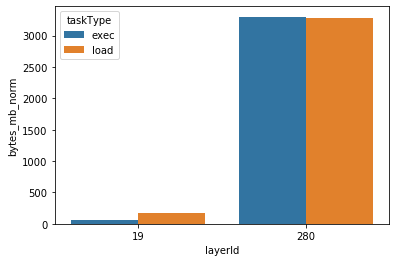

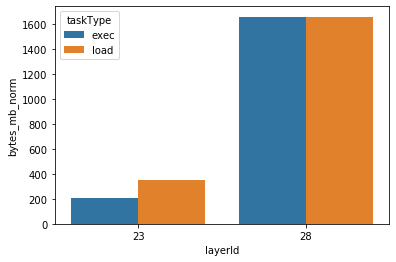

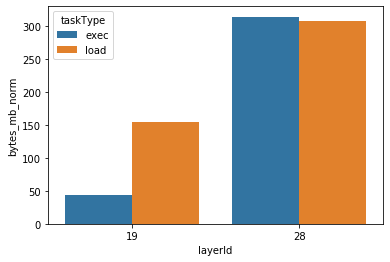

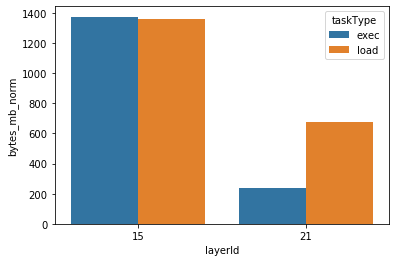

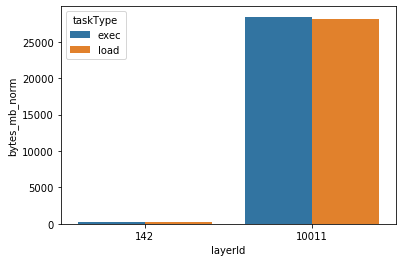

In [9]:
# for networkName in combined.network.unique():
#     plot_data = combined[combined.network == networkName]
#     sns.barplot(x="layerId", y="bytes_mb_norm", hue="taskType", data=plot_data)
#     plt.title(networkName)
#     plt.show()

# Define the number of layers for convolutional and fully connected
ageNet_layers = {'conv': 12, 'fc':8}
genderNet_layers = {'conv': 12, 'fc':8}
faceNet_layers = {'conv': 17, 'fc':8}
sos_Alex_layers = {'conv': 16, 'fc':6}
sos_Google_layers = {'conv': 10, 'fc':142}
    
split_df = combined
split_AgeNet = split_df[split_df.network == 'AgeNet']
split_AgeNet = split_AgeNet[split_AgeNet.layerId >= 0]
ageNet_conv = split_AgeNet[split_AgeNet.layerId < ageNet_layers['fc']]
ageNet_fc = split_AgeNet[split_AgeNet.layerId >= ageNet_layers['fc']]
merged = [ageNet_conv.groupby('taskType').sum().reset_index(), ageNet_fc.groupby('taskType').max().reset_index()]
merged_df = pd.concat(merged)
merged_df
sns.barplot(x="layerId", y="bytes_mb_norm", hue="taskType", data=merged_df)
plt.show()
split_df = list_of_df[0]
split_AgeNet = split_df[split_df.network == 'FaceNet']
split_AgeNet = split_AgeNet[split_AgeNet.layerId >= 0]
ageNet_conv = split_AgeNet[split_AgeNet.layerId < faceNet_layers['fc']]
ageNet_fc = split_AgeNet[split_AgeNet.layerId >= faceNet_layers['fc']]
merged = [ageNet_conv.groupby('taskType').sum().reset_index(), ageNet_fc.groupby('taskType').max().reset_index()]
merged_df = pd.concat(merged)
merged_df
sns.barplot(x="layerId", y="bytes_mb_norm", hue="taskType", data=merged_df)
plt.show()

split_df = list_of_df[0]
split_AgeNet = split_df[split_df.network == 'GenderNet']
split_AgeNet = split_AgeNet[split_AgeNet.layerId >= 0]
ageNet_conv = split_AgeNet[split_AgeNet.layerId < genderNet_layers['fc']]
ageNet_fc = split_AgeNet[split_AgeNet.layerId >= genderNet_layers['fc']]
merged = [ageNet_conv.groupby('taskType').sum().reset_index(), ageNet_fc.groupby('taskType').max().reset_index()]
merged_df = pd.concat(merged)
merged_df
sns.barplot(x="layerId", y="bytes_mb_norm", hue="taskType", data=merged_df)
plt.show()
split_df = list_of_df[0]
split_AgeNet = split_df[split_df.network == 'Salient Object Subitizing']
split_AgeNet = split_AgeNet[split_AgeNet.layerId >= 0]
ageNet_conv = split_AgeNet[split_AgeNet.layerId < sos_Alex_layers['fc']]
ageNet_fc = split_AgeNet[split_AgeNet.layerId >= sos_Alex_layers['fc']]
merged = [ageNet_conv.groupby('taskType').sum().reset_index(), ageNet_fc.groupby('taskType').max().reset_index()]
merged_df = pd.concat(merged)
merged_df
sns.barplot(x="layerId", y="bytes_mb_norm", hue="taskType", data=merged_df)
plt.show()

split_df = list_of_df[0]
split_AgeNet = split_df[split_df.network == 'Salient Object Subitizing_google']
split_AgeNet = split_AgeNet[split_AgeNet.layerId >= 0]
ageNet_conv = split_AgeNet[split_AgeNet.layerId < sos_Google_layers['fc']]
ageNet_fc = split_AgeNet[split_AgeNet.layerId >= sos_Google_layers['fc']]
merged = [ageNet_conv.groupby('taskType').sum().reset_index(), ageNet_fc.groupby('taskType').max().reset_index()]
merged_df = pd.concat(merged)
merged_df
sns.barplot(x="layerId", y="bytes_mb_norm", hue="taskType", data=merged_df)
plt.show()

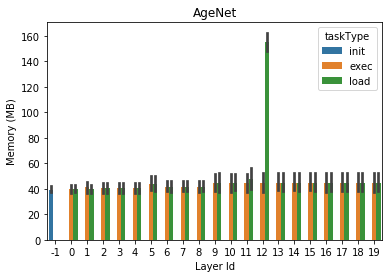

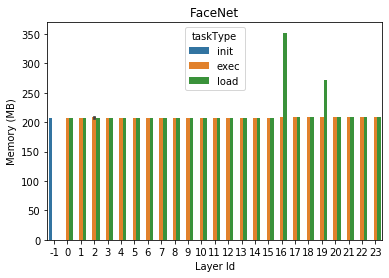

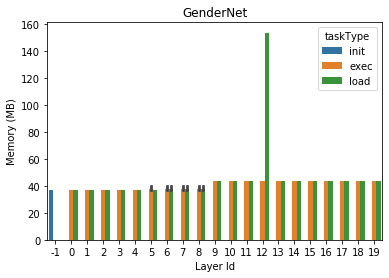

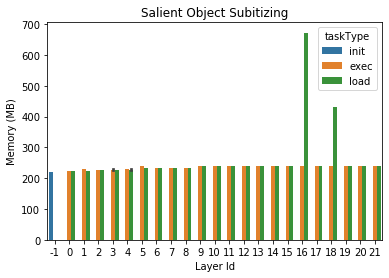

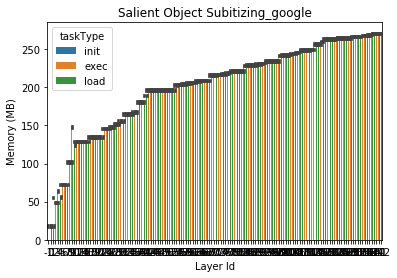

In [12]:
for networkName in combined.network.unique():
    plot_data = combined[combined.network == networkName]
    sns.barplot(x="layerId", y="bytes_mb_norm", hue="taskType", data=plot_data)
    
    plt.title(networkName)
    plt.xlabel('Layer Id')
    plt.ylabel('Memory (MB)')
    plt.savefig('mem_per_layer_network_{}.png'.format(networkName.replace(" ", "_")))
    plt.show()